# ME Assignment
1. Implement the EM algorithm for clustering with multivariate Gaussian models
discussed in the LearningGM section. Initialize the algorithm with the K-means result
(for example Matlab provides a kmeans function). Assume there are only two clusters.
Report the parameters $\pi_k$, $\mu_k$, $\Sigma_k$, $k = 1, 2$ for the following datasets containing
$500-600$ observations from $\mathbb{R}^2$:



#### Import dependencies

In [371]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from os.path import join
from scipy.stats import multivariate_normal
from itertools import repeat
from random import randint

#### Data loading functions

In [372]:
def get_xeasy():
    return load_data("xeasy.txt")

def get_x1():
    return load_data("x1.txt")

def get_x2():
    return load_data("x2.txt")

def load_data(filename):
    path = "data/EM/"
    data = np.loadtxt(join(path,filename), delimiter=',')
    return data


#### EM Algorithm

In [373]:
def EM(data, num_clusters, ):
    #use kmeans to initialize cluster centers
    kmeans = KMeans(n_clusters=num_clusters)
    prediction_labels = np.asarray(kmeans.fit_predict(data))
    cluster_centroids = np.asarray(kmeans.cluster_centers_)
    cluster_variances = np.asarray([np.sum(np.square(data[prediction_labels==k]))/(prediction_labels.size-1)
                         for k in range(num_clusters)])
    mixture_proportions = np.asarray([np.sum(prediction_labels==k)/prediction_labels.size for k in range(num_clusters)])

    return EM_loop(data,cluster_centroids, cluster_variances, mixture_proportions, num_clusters)

def print_EM(data):
    cluster_centroids, cluster_variances, mixture_proportions, ll_list = EM(data, 2)
    print("Cluster centroids (mu):\n", cluster_centroids)
    print("Cluster Covariances (sigma):\n", cluster_variances)
    print("Proportions (pi):\n",mixture_proportions)
    plt.plot(ll_list)
    plt.title("Loss vs iteration")
    plt.show()

def EM_loop(data,cluster_centroids, cluster_variances, mixture_proportions, num_clusters):
    converged = False
    counter = 0
    ll_list = []
    while not converged:
        counter += 1
        if counter == 10000:
            break
        # expectation step
        denominator = np.sum(np.asarray(list(map(pdf, repeat(data), cluster_centroids, cluster_variances, mixture_proportions))), axis=0)
        prediction_labels=[pdf(data, centroid, variance, proportion)/denominator for centroid, variance, proportion in
                           zip(cluster_centroids, cluster_variances, mixture_proportions)]
        prediction_labels = np.asarray(prediction_labels).T

        # maximization step
        new_cluster_centroids = np.asarray([np.average(data, weights=prediction_labels[:,k], axis=0) for k in range(num_clusters)])
        new_mixture_proportions = np.asarray([np.mean(prediction_labels[:,k]) for k in range(num_clusters)])
        new_cluster_variances = np.asarray([prediction_labels[:,k]*(data-cluster_centroids[k]).T@(data-cluster_centroids[k])/np.sum(prediction_labels[:,k])
                         for k in range(num_clusters)])

        # check if converged
        if(np.allclose(new_cluster_centroids, cluster_centroids) and
           np.allclose(new_cluster_variances, cluster_variances) and
           np.allclose(new_mixture_proportions, mixture_proportions)):
            converged = True

        # update parameters
        cluster_centroids = new_cluster_centroids
        cluster_variances = new_cluster_variances
        mixture_proportions = new_mixture_proportions

        ll = -np.sum(np.log(np.sum(list(map(pdf, repeat(data), cluster_centroids, cluster_variances, mixture_proportions)),axis=0)))
        ll_list.append(ll)
    # uncomment to see plot
    plot_clusters(data, prediction_labels)
    return cluster_centroids, cluster_variances, mixture_proportions, ll_list

def print_proven_EM(data):
    cluster_centroids, cluster_variances, mixture_proportions, ll_list = EM(data, 8)

    # remove all clusters with proportion < .25
    cluster_centroids = cluster_centroids[mixture_proportions<.25]
    cluster_variances = cluster_variances[mixture_proportions<.25]
    mixture_proportions = mixture_proportions[mixture_proportions<.25]

    # select most distance centers
    random_index = randint(0, mixture_proportions.size-1)
    furthest_index = np.argmax(np.linalg.norm(cluster_centroids - cluster_centroids[random_index]))
    indexes_to_keep = [random_index, furthest_index]

    cluster_centroids = cluster_centroids[indexes_to_keep]
    cluster_variances = cluster_variances[indexes_to_keep]
    mixture_proportions = mixture_proportions[indexes_to_keep]

    cluster_centroids, cluster_variances, mixture_proportions, ll_list = \
        EM_loop(data,cluster_centroids, cluster_variances, mixture_proportions, 2)

    print("Cluster centroids (mu):\n", cluster_centroids)
    print("Cluster Covariance (sigma):\n", cluster_variances)
    print("Proportions (pi)\n",mixture_proportions)
    plt.title("Loss vs iteration")
    plt.plot(ll_list)
    plt.show()

def pdf(data, centroid, variance, proportion):
    return multivariate_normal.pdf(data, centroid, variance)*proportion

def plot_clusters(data, prediction_labels):
    # Show scatterplot with labels
    for prediction in prediction_labels.T:
        group = data[prediction > 1/prediction_labels.shape[1]]
        plt.scatter(group[:,0], group[:,1])
    plt.show()


## 1a. xeasy


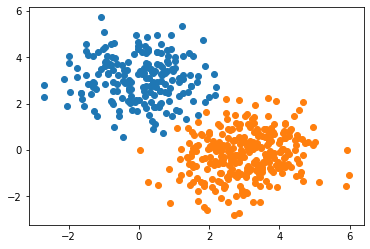

Cluster centroids (mu):
 [[ 0.02847698  3.07051184]
 [ 3.01886079 -0.17711201]]
Cluster Covariances (sigma):
 [[[ 1.01849521 -0.05861085]
  [-0.05861085  0.95457513]]

 [[ 1.00528737  0.16007202]
  [ 0.16007202  0.94210842]]]
Proportions (pi):
 [0.40884239 0.59115761]


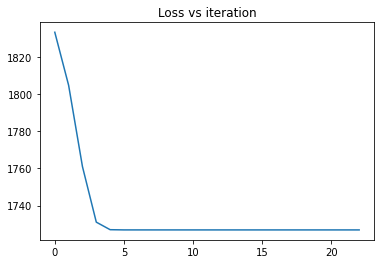

In [374]:
print_EM(get_xeasy())

## 1b. x1


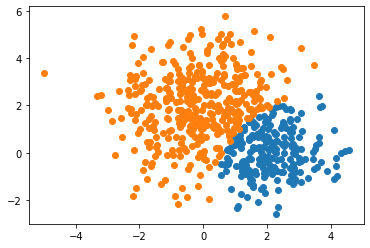

Cluster centroids (mu):
 [[ 2.08440675  0.1243803 ]
 [-0.10044296  1.9731468 ]]
Cluster Covariances (sigma):
 [[[ 0.86255326 -0.03892014]
  [-0.03892014  1.05827829]]

 [[ 1.70416796  0.14864789]
  [ 0.14864789  2.19990437]]]
Proportions (pi):
 [0.34725824 0.65274176]


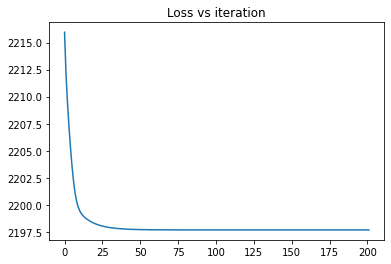

In [375]:
print_EM(get_x1())

## 1c. x2


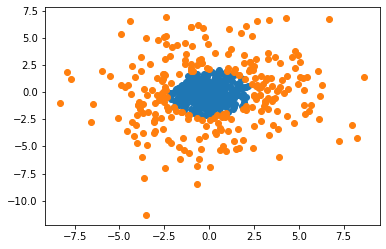

Cluster centroids (mu):
 [[ 0.0142441  -0.04651445]
 [ 0.1780945  -0.12519426]]
Cluster Covariances (sigma):
 [[[1.06250523 0.06633611]
  [0.06633611 0.88826221]]

 [[9.25806211 0.7678193 ]
  [0.7678193  9.41427237]]]
Proportions (pi):
 [0.51196426 0.48803574]


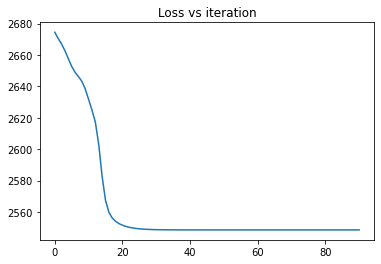

In [376]:
print_EM(get_x2())

## 2a. xeasy


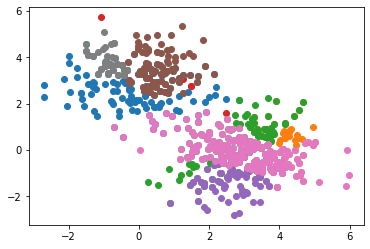

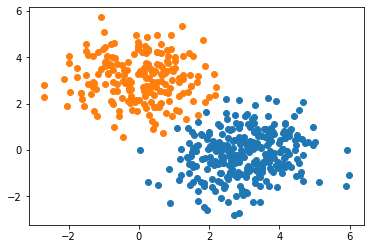

Cluster centroids (mu):
 [[ 3.01886077 -0.17711199]
 [ 0.02847695  3.07051187]]
Cluster Covariance (sigma):
 [[[ 1.00528739  0.16007199]
  [ 0.16007199  0.94210844]]

 [[ 1.01849517 -0.0586108 ]
  [-0.0586108   0.95457508]]]
Proportions (pi)
 [0.59115762 0.40884238]


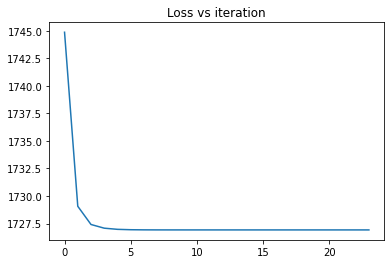

In [377]:
print_proven_EM(get_xeasy())

## 2b. x1


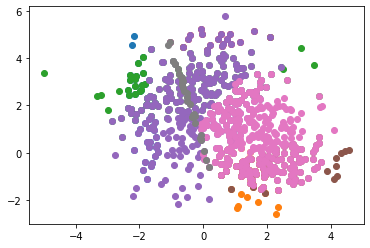

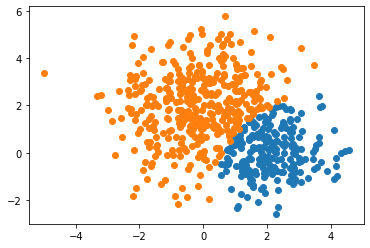

Cluster centroids (mu):
 [[ 2.08440621  0.12438093]
 [-0.10044359  1.97314725]]
Cluster Covariance (sigma):
 [[[ 0.86255361 -0.03892037]
  [-0.03892037  1.05827897]]

 [[ 1.70416735  0.14864855]
  [ 0.14864855  2.19990429]]]
Proportions (pi)
 [0.34725851 0.65274149]


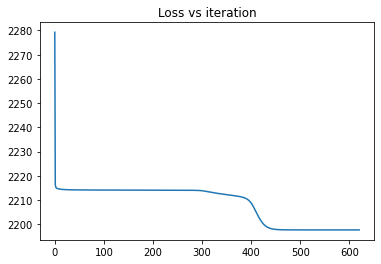

In [378]:
print_proven_EM(get_x1())

## 2c. x2


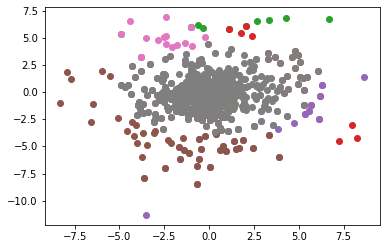

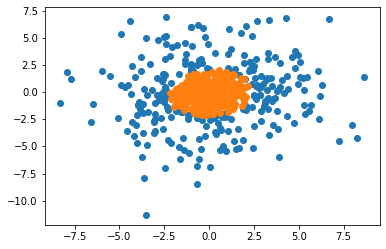

Cluster centroids (mu):
 [[ 0.1780945  -0.12519428]
 [ 0.01424412 -0.04651444]]
Cluster Covariance (sigma):
 [[[9.25806287 0.76781934]
  [0.76781934 9.41427334]]

 [[1.0625055  0.06633616]
  [0.06633616 0.88826232]]]
Proportions (pi)
 [0.48803568 0.51196432]


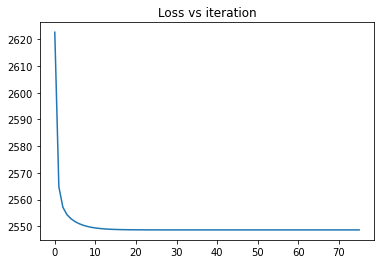

In [379]:
print_proven_EM(get_x2())
